## Imports

In [8]:
import gradio as gr
import pandas as pd
import tensorflow as tf
import spacy
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from timeit import default_timer as timer
from helper_functions import plot_pie_chart, preprocess_text, plot_training_history, preprocess_single_sentence
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [9]:
DIR= 'kaggle/input/emotion-dataset-for-nlp/'
TRAIN_FILE = 'train.txt'
VAL_FILE = 'val.txt'
TEST_FILE = 'test.txt'

In [10]:
train_df = pd.read_csv(DIR+TRAIN_FILE, delimiter=';', header=None, names=['text', 'label'])
val_df = pd.read_csv(DIR+VAL_FILE, delimiter=';', header=None, names=['text', 'label'])
test_df = pd.read_csv(DIR+TEST_FILE, delimiter=';', header=None, names=['text', 'label'])

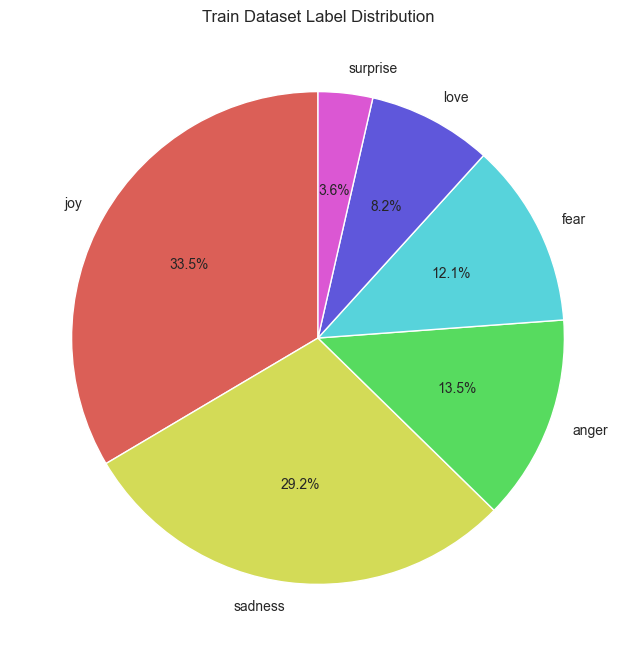

In [11]:
plot_pie_chart(train_df, 'Train Dataset')

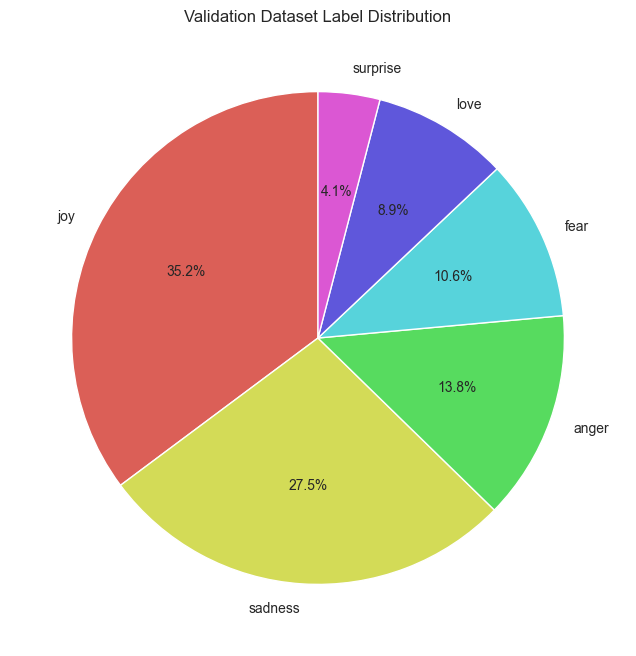

In [12]:
plot_pie_chart(val_df, 'Validation Dataset')

## Preprocessing

In [13]:
%%writefile helper_functions.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import spacy

with open('kaggle/label_names.txt', 'r') as f:
    labels = [emotion.strip() for emotion in f.readlines()] 
    
encoder= LabelEncoder()
encoder.fit(labels)

nlp = spacy.load("en_core_web_sm")


def plot_pie_chart(data_frame: pd.DataFrame, title: str) -> None:
    """
    Plot a pie chart to visualize label distribution in the provided DataFrame.

    Args:
        data_frame (pd.DataFrame): The DataFrame containing the data to visualize.
        title (str): The title for the pie chart.

    Returns:
        None
    """
    label_count = data_frame['label'].value_counts()
    plt.figure(figsize=(8, 8))
    sns.set_style("whitegrid")
    plt.pie(label_count, labels=label_count.index, colors=sns.color_palette("hls", len(label_count.index)), autopct='%1.1f%%', startangle=90)
    plt.title(f"{title} Label Distribution")
    plt.show()
    plt.close()

def preprocess_text(df: pd.DataFrame, emotions: list=['love', 'surprise']):
    """
    Preprocesses text data in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing 'sentence' and 'label' columns.
        encoder (LabelEncoder): Label encoder for the labels.
        emotions (list): List of emotions to drop from the DataFrame.

    Returns:
        pd.DataFrame: DataFrame with preprocessed text and encoded labels.
    # """
    for i in emotions:
        df = df[df['label'] != i]

    df['processed_text'] = df['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x) if not token.is_stop and not token.is_punct and not token.is_space]))

    df['label_num'] = encoder.transform(df['label'])
    df.drop(columns=['text', 'label'], inplace=True)
    return df

def preprocess_single_sentence(sentence):
    """
    Preprocesses a single sentence.

    Args:
        sentence (str): Input sentence.

    Returns:
        str: Preprocessed and tokenized sentence.
    """
    processed_text = ' '.join([token.lemma_ for token in nlp(sentence) if not token.is_stop and not token.is_punct and not token.is_space])
    return processed_text

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss curves.

    Parameters:
    history (History object): History object returned by model.fit() containing training metrics.

    Returns:
    None
    """
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


Overwriting helper_functions.py


In [14]:
train_df= preprocess_text(train_df)
val_df= preprocess_text(val_df)

## Visualisation

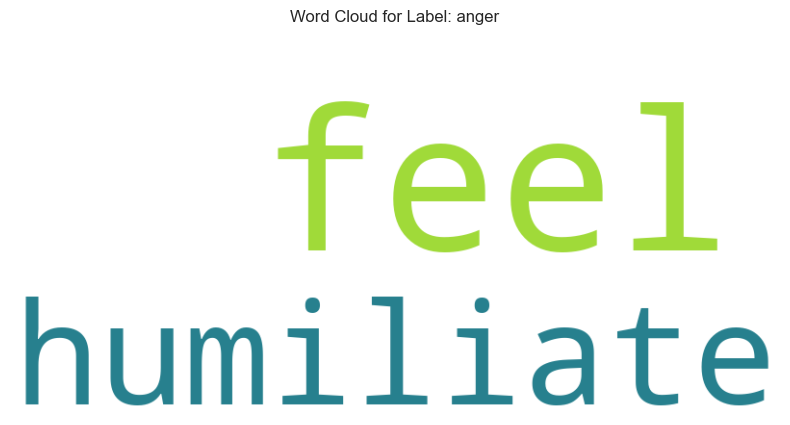

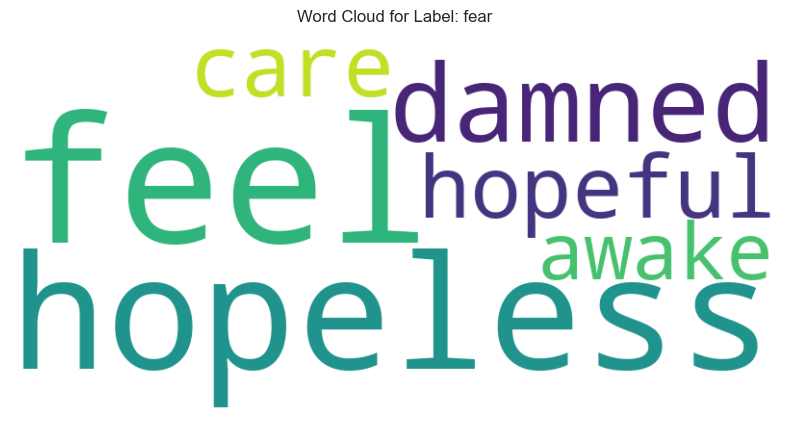

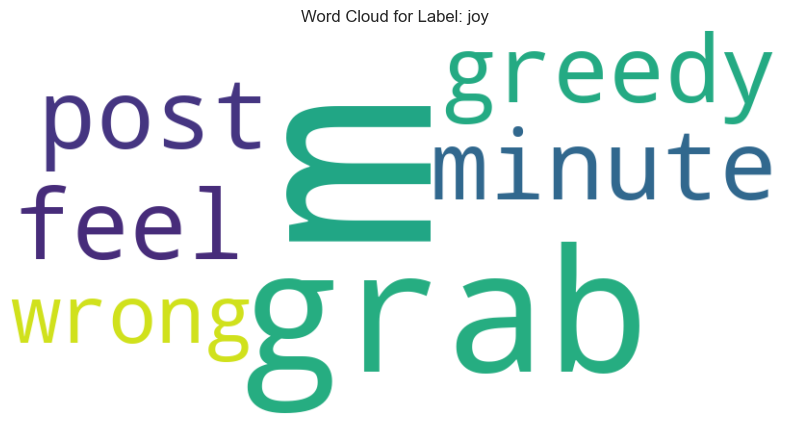

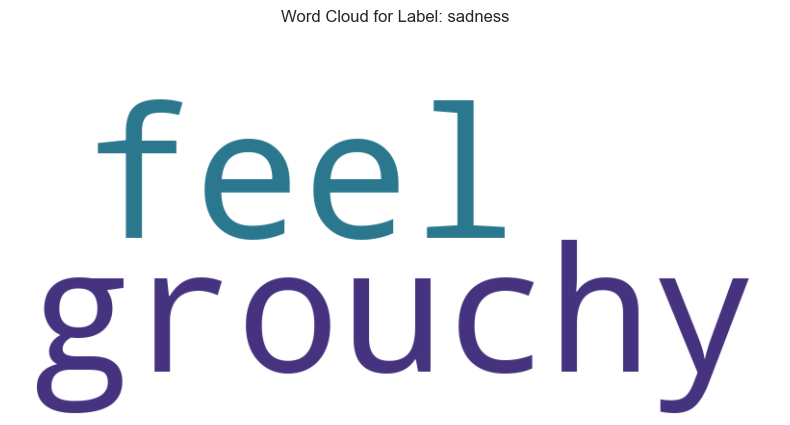

In [15]:
with open('kaggle/label_names.txt', 'r') as f:
    labels = [emotion.strip() for emotion in f.readlines()] 

# Generate and plot word cloud for each label
for class_label, text in zip(labels, train_df['processed_text']):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {class_label}')
    plt.axis('off')
    plt.show()


## Model

In [16]:
VOCAB_SIZE= 15000
text_vect_layer= tf.keras.layers.TextVectorization(max_tokens= VOCAB_SIZE)
text_vect_layer.adapt(train_df['processed_text'])

In [17]:
EMBEDDING_UNITS= 64
UNITS= 64
DROPOUT= 0.2

model_v1= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim=text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.GRU(UNITS, dropout= DROPOUT, return_sequences= True),
    layers.GRU(UNITS, dropout= DROPOUT),
    layers.Dense(len(labels), activation= 'sigmoid')
])

model_v2= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim=text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.LSTM(UNITS, dropout= DROPOUT, return_sequences= True),
    layers.LSTM(UNITS, dropout= DROPOUT),
    layers.Dense(len(labels), activation= 'sigmoid')
])


In [18]:
model_v1.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
model_v2.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [19]:
BATCH_SIZE= 32  
train_set= tf.data.Dataset.from_tensor_slices((train_df['processed_text'].values, train_df['label_num'].values)).batch(BATCH_SIZE)
val_set= tf.data.Dataset.from_tensor_slices((val_df['processed_text'].values, val_df['label_num'].values)).batch(BATCH_SIZE)

In [20]:
history_model_v1= model_v1.fit(train_set, validation_data= val_set, epochs= 5)

Epoch 1/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5472 - loss: 1.0125 - val_accuracy: 0.9276 - val_loss: 0.2128
Epoch 2/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9427 - loss: 0.1638 - val_accuracy: 0.9483 - val_loss: 0.1453
Epoch 3/5
 77/442 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9727 - loss: 0.0787

In [ ]:
history_model_v2= model_v2.fit(train_set, validation_data= val_set, epochs= 5)

## Evaluating the model

In [ ]:
test_df= preprocess_text(test_df)
test_set= tf.data.Dataset.from_tensor_slices((test_df['processed_text'].values, test_df['label_num'].values)).batch(BATCH_SIZE)

In [ ]:
eval_model_v1= model_v1.evaluate(test_set)
eval_model_v2= model_v2.evaluate(test_set)

## Plotting the losses and accuracy

In [ ]:
plot_training_history(history_model_v1)
plot_training_history(history_model_v2)

## Saving the model

In [ ]:
gru_model= 'models/gru_model.keras'
lstm_model= 'models/lstm_model.keras'
model_v1.save(gru_model)
model_v2.save(lstm_model)

## Predictions for a single sentence
To make predictions on a single sentence, we need to do the following steps:
1. Process it in the same manner to remove the extra token words such (as punctuations)
2. Expand the dimension.
3. Pass through the model.

In [ ]:
with open('kaggle/examples.txt', 'r') as f:
    example_list = [example.strip() for example in f.readlines()]

encoder= LabelEncoder()
encoder.fit(labels) 

model = tf.keras.models.load_model(gru_model)

nlp = spacy.load("en_core_web_sm")

def predict(text):
    """
    Make predictions on the given text using the trained model.

    Args:
        text (str): The text to make predictions on.

    Returns:
        list: A list of predictions.
    """
    start_time= timer()
    text= preprocess_single_sentence(text)
    text= tf.expand_dims(text, 0)

    probability = model.predict(text)
    pred_label_with_prob= {labels[i]: float(probability[0][i]) for i in range(len(labels))} 
    pred_time = round(timer() - start_time, 5)
    return pred_label_with_prob, pred_time

### Gradio App
input= gr.Textbox(lines=5, label="Enter text", placeholder="i like to have the same breathless feeling as a reader eager to see what will happen next")
outputs=[
        gr.Label(num_top_classes=len(labels), label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ]
title= ' Sentiment Analysis 🤣😱😡😢 '
description= 'The sentiment analysis model is a deep learning-based natural language processing (NLP) model designed to analyze and classify the sentiment expressed in text data. It is trained to understand the emotional tone of text and categorize it into predefined sentiment categories such as <b>anger, fear, saddness and joy.<b>'
demo= gr.Interface(fn=predict, 
                   inputs=input, 
                   outputs=outputs, 
                   title=title, 
                   description=description,
                   examples= example_list
                  )
demo.launch()